In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
%reload_ext autoreload
%autoreload 2

# EDA

Set a predetermined seed so all our results can be replicated

In [3]:
RANDOM_SEED = 1337

### Data Source Description
- Raw data can be downloaded from: https://www.kaggle.com/datasets/abhinav89/telecom-customer?resource=download
- Data can be cleaned by running clean_raw.py in the repository to get the data into the form used in this notebook.
- Data was originally provided by Teradata Center for Customer Relationship Management, located at the Fuqua School of Business, Duke University for a tournament in 2002. 
    - The data was compiled for a three month period and then whether or not the customers churned in the fifth month was recorded (churn data has a one month lag as the industry requires a month to predict and setup any campaigns to target potential churn customers, hence only churn data in the lagged month is relevant for business decisions)
    - As the original dataset and many of the descriptions of variables within the data are no longer available, the data we are working with is only a subset of the original data. 

In [239]:
full_data = pd.read_csv('Dataset/clean_data.csv', index_col='Customer_ID')

- Data contains 100,000 rows and 96 features
- Customer_ID serves as the primary key for each customer 
- Target variable is 'churn' where
    -  1 = Customer Churned
    -  0 = Customer Stayed

In [240]:
full_data.shape

(100000, 96)

In [211]:
full_data.head(5)

,actvsubs,adjmou,adjqty,adjrev,adults,area,asl_flag,attempt_mean,avg3mou,avg3qty,...,threeway_mean,totcalls,totmou,totmrc_mean,totrev,truck,unan_dat_mean,unan_vce_mean,uniqsubs,vceovr_mean
Customer_ID,,,,,,,,,,,,,,,,,,,,,
1000001,1,4085.00,1602,1453.44,1.0,NORTHWEST/ROCKY MOUNTAIN AREA,0,52.333333,272,116,...,0.000000,1652,4228.00000,22.500,1504.62,0.0,0.0,6.333333,2,0.0
1000002,1,26367.00,14624,2833.88,1.0,CHICAGO AREA,0,263.333333,305,158,...,0.333333,14654,26400.00000,37.425,2851.68,1.0,0.0,61.333333,1,9.1
1000003,1,24303.05,7888,1934.47,2.0,GREAT LAKES AREA,0,9.000000,12,7,...,0.000000,7903,24385.05333,16.990,2155.91,0.0,0.0,2.666667,1,0.0
1000004,1,3035.00,1479,1941.81,4.0,CHICAGO AREA,0,3.666667,8,3,...,0.000000,1502,3065.00000,38.000,2000.90,0.0,0.0,0.000000,1,0.0
1000005,1,13965.00,4452,2166.48,1.0,NEW ENGLAND AREA,0,222.333333,558,191,...,0.000000,4485,14028.00000,71.980,2181.12,0.0,0.0,77.000000,1,0.0


In [96]:
#Column descriptions are scraped from the kaggle website via beautifulsoup. 
#It's been packaged in this repository for convenience's sake. 
with open('columnDescriptions.json','r') as f:
    col_desc = json.load(f)

Our target variable in the data is surprisingly well balanced to begin with. We might still input some weights when building the model later just to make sure but this hopefully means detecting positive cases (churned customers) much easier. 

<AxesSubplot:xlabel='churn', ylabel='count'>

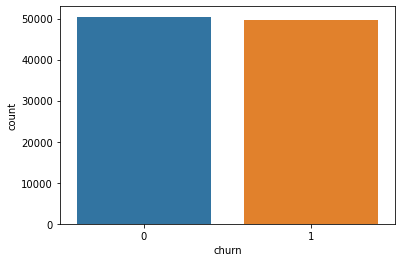

In [6]:
sns.countplot(x=full_data.churn)

Some of the columns within our data cannot be reliably imputed by our preprocessing, hence there are some columns still with missing data as seen below. We're hoping to use algorithms that can handle missing data since some of it may be MNAR with a lot of rows missing, but we'll take other steps to address the missingness if need be later. 

Text(0.5, 1.0, '% Data Missing in Each Column')

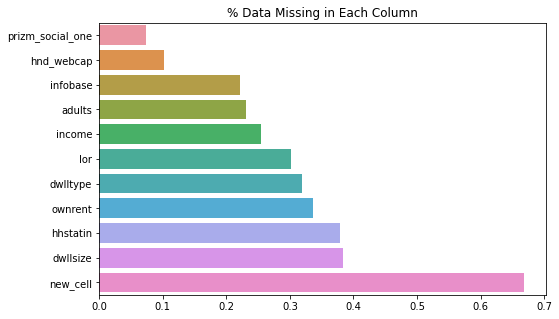

In [212]:
miss_data_cols = full_data.columns[full_data.isna().sum()>0]
pct_miss_data = (
    full_data[miss_data_cols].isna().sum()
    .sort_values()
    /full_data.shape[0]
)
plt.figure(figsize=(8,5))
ax = sns.barplot(x=pct_miss_data,y=pct_miss_data.index)
ax.set_title('% Data Missing in Each Column')

# Univariate Analysis

In [241]:
cat_cols = full_data.select_dtypes(include='object').columns
num_cols = full_data.select_dtypes(include=np.number).columns
bin_cols = num_cols[full_data[num_cols].nunique()==2]
num_cols = pd.Index(set(num_cols)-set(bin_cols))


## Categorical Features

In [242]:
from graph_utils import get_subplot_dim

In [243]:
full_data[cat_cols].head(5)

,area,crclscod,dualband,hnd_webcap,marital,prizm_social_one
Customer_ID,,,,,,
1000001,NORTHWEST/ROCKY MOUNTAIN AREA,A,Y,WCMB,single,suburb
1000002,CHICAGO AREA,EA,N,WC,single,urban
1000003,GREAT LAKES AREA,C,N,NaN,married,suburb
1000004,CHICAGO AREA,B,N,NaN,married,town
1000005,NEW ENGLAND AREA,A,Y,WCMB,single,urban


### Categorical Feature Distribution

Categorical Data Insights
- The data is from a U.S based company with customers across the nation
- Credit class code is likely sourced from a credit reporting agency such as Experian
- 

Text(0.5, 0, 'Percentage of Data From Each Area')

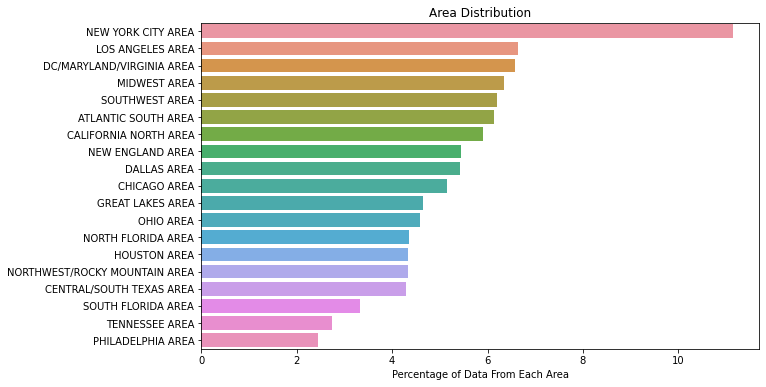

In [204]:
plt.figure(figsize=(10,6))
area_count = full_data['area'].value_counts()/full_data.shape[0]*100
ax = sns.barplot(
    x=area_count,
    y=area_count.index
)
ax.set_title('Area Distribution')
ax.set_xlabel('Percentage of Data From Each Area')

Text(0.5, 0, 'Percentage of Data From Each Class')

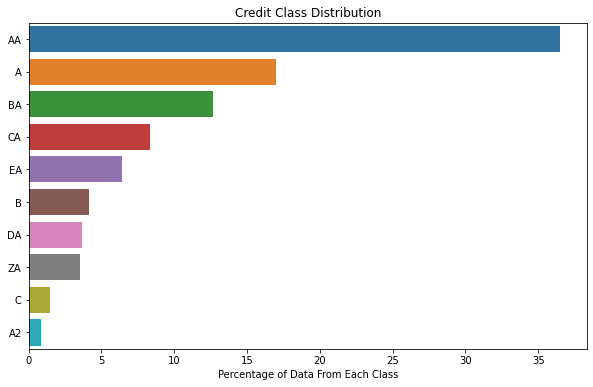

In [209]:
#Only 10 of the top most common credit classes
#out of 54 are displayed to save on clutter
plt.figure(figsize=(10,6))
credit_class_count = (
    full_data['crclscod'].value_counts().head(10)
    /full_data.shape[0]*100
)
ax = sns.barplot(
    x=credit_class_count,
    y=credit_class_count.index
)
ax.set_title('Credit Class Distribution')
ax.set_xlabel('Percentage of Data From Each Class')

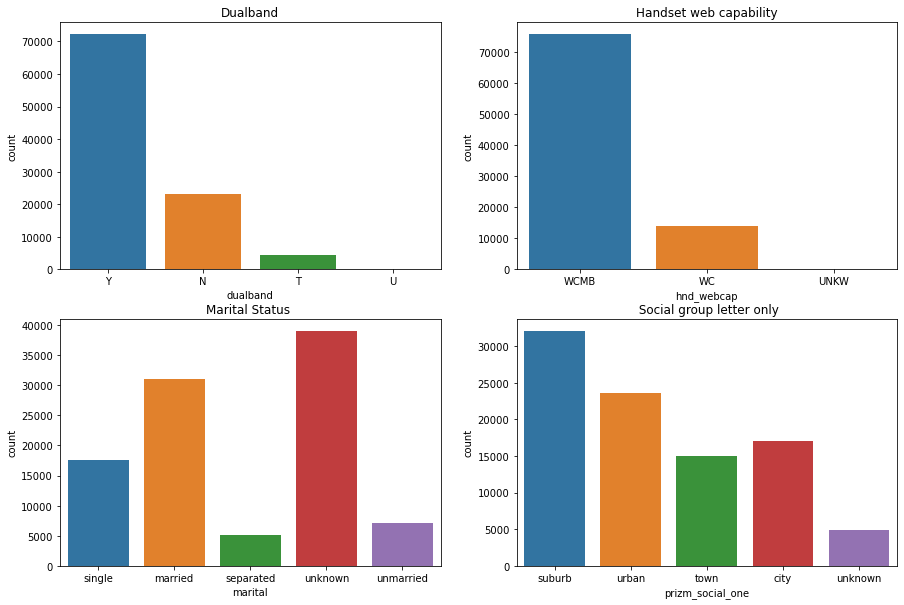

In [245]:
minor_cat_cols = cat_cols[full_data[cat_cols].nunique()<10]
r, c = get_subplot_dim(len(minor_cat_cols))
fig, ax = plt.subplots(r,c,figsize=(15,10))
for col, subplot in zip(minor_cat_cols,ax.flatten()):
    sub_ax = sns.countplot(x=full_data[col],ax=subplot)
    sub_ax.set_title(f'{col_desc[col]}')